In [1]:
import numpy as np
import pandas as pd

In [2]:
pd.options.plotting.backend = "plotly"

In [3]:
%cd ..

/home/pwd/Codes/hadithi/dev.io


# About Dataset
## Marketing A/B testing dataset

Marketing companies want to run successful campaigns, but the market is complex and several options can work. So normally they tun A/B tests, that is a randomized experimentation process wherein two or more versions of a variable (web page, page element, banner, etc.) are shown to different segments of people at the same time to determine which version leaves the maximum impact and drive business metrics.

The companies are interested in answering two questions:

- Would the campaign be successful?
- If the campaign was successful, how much of that success could be attributed to the ads?

With the second question in mind, we normally do an A/B test. The majority of the people will be exposed to ads (the experimental group). And a small portion of people (the control group) would instead see a Public Service Announcement (PSA) (or nothing) in the exact size and place the ad would normally be.

The idea of the dataset is to analyze the groups, find if the ads were successful, how much the company can make from the ads, and if the difference between the groups is statistically significant.

Data dictionary:

- Index: Row index
- user id: User ID (unique)
- test group: If "ad" the person saw the advertisement, if "psa" they only saw the public service announcement
- converted: If a person bought the product then True, else is False
- total ads: Amount of ads seen by person
- most ads day: Day that the person saw the biggest amount of ads
- most ads hour: Hour of day that the person saw the biggest amount of ads

In [4]:
dataf = pd.read_csv("assets/marketing_AB.csv.zip", index_col=0)
dataf.sample(4)

,user id,test group,converted,total ads,most ads day,most ads hour
521247,1560520,ad,False,24,Thursday,17
245143,1509498,ad,False,11,Sunday,13
372216,1464380,ad,False,21,Monday,19
87445,1419555,ad,False,34,Monday,13


In [5]:
dataf.dtypes

user id           int64
test group       object
converted          bool
total ads         int64
most ads day     object
most ads hour     int64
dtype: object

In [6]:
(
    dataf.isna()
    .sum()
    .div(dataf.shape[0])
    .to_frame()
    .rename(columns={0: "% missing values"})
    .style.format({"% missing values": "{:.1%}"})
)

,% missing values
user id,0.0%
test group,0.0%
converted,0.0%
total ads,0.0%
most ads day,0.0%
most ads hour,0.0%


In [7]:
dataf.describe(include="object").T

,count,unique,top,freq
test group,588101,2,ad,564577
most ads day,588101,7,Friday,92608


In [8]:
(
    dataf.loc[:, ~dataf.columns.str.contains("id")]
    .describe(include=np.number)
    .T.convert_dtypes()
    .style.format({"mean": "{:.2f}", "std": "{:.2f}"})
)

,count,mean,std,min,25%,50%,75%,max
user id,588101,1310692.22,202225.98,900000,1143190,1313725,1484088,1654483
total ads,588101,24.82,43.72,1,4,13,27,2065
most ads hour,588101,14.47,4.83,0,11,14,18,23


In [9]:
dataf.columns = dataf.columns.str.replace(" ", "_")

In [10]:
dataf.head()

,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


In [11]:
# naive probability

(
    dataf.groupby(by="test_group")
    .agg({"converted": ("sum", "count")})
    .T.reset_index(drop=True)
    .T.rename(columns={0: "converted", 1: "population"})
    .assign(probability=lambda d: d["converted"] / d["population"])
)

,converted,population,probability
test_group,,,
ad,14423,564577,0.025547
psa,420,23524,0.017854


In [12]:
(
    dataf.groupby(by=["test_group", "most_ads_day"])
    .agg({"converted": ("sum", "count")})
    .T.reset_index(drop=True)
    .T.rename(columns={0: "converted", 1: "population"})
    .assign(probability=lambda d: d["converted"] / d["population"])
)

converted  population  probability
test_group most_ads_day                                    
ad         Friday             1995       88805     0.022465
           Monday             2778       83571     0.033241
           Saturday           1679       78802     0.021307
           Sunday             2027       82332     0.024620
           Thursday           1711       79077     0.021637
           Tuesday            2270       74572     0.030440
           Wednesday          1963       77418     0.025356
psa        Friday               62        3803     0.016303
           Monday               79        3502     0.022559
           Saturday             40        2858     0.013996
           Sunday               63        3059     0.020595
           Thursday             79        3905     0.020230
           Tuesday              42        2907     0.014448
           Wednesday            55        3490     0.015759

In [13]:
(
    dataf.groupby(by=["most_ads_day", "test_group"])
    .agg({"converted": ("sum", "count")})
    .T.reset_index(drop=True)
    .T.rename(columns={0: "converted", 1: "population"})
    .assign(probability=lambda d: d["converted"] / d["population"])
)

converted  population  probability
most_ads_day test_group                                    
Friday       ad               1995       88805     0.022465
             psa                62        3803     0.016303
Monday       ad               2778       83571     0.033241
             psa                79        3502     0.022559
Saturday     ad               1679       78802     0.021307
             psa                40        2858     0.013996
Sunday       ad               2027       82332     0.024620
             psa                63        3059     0.020595
Thursday     ad               1711       79077     0.021637
             psa                79        3905     0.020230
Tuesday      ad               2270       74572     0.030440
             psa                42        2907     0.014448
Wednesday    ad               1963       77418     0.025356
             psa                55        3490     0.015759

In [14]:
# naive probability with PyMc

(
    dataf.groupby(by="test_group")
    .agg({"converted": ("sum", "count")})
    .T.reset_index(drop=True)
    .T.rename(columns={0: "converted", 1: "population"})
)

,converted,population
test_group,,
ad,14423,564577
psa,420,23524


In [15]:
import pymc as pm
import arviz as az

In [16]:
summarized_df = (
    dataf.groupby(by="test_group")
    .agg({"converted": ("sum", "count")})
    .T.reset_index(drop=True)
    .T.rename(columns={0: "converted", 1: "population"})
)

converted = summarized_df["converted"].to_numpy()
population = summarized_df["population"].to_numpy()
coords = {"test_group": summarized_df.index}

In [17]:
with pm.Model(coords=coords) as model:
    p_convert = pm.Beta(
        "p_convert", 2, 2, dims="test_group"
    )  # alpha (α) and beta (β) of 2
    pm.Binomial("y", p=p_convert, n=population, observed=converted)

In [18]:
model

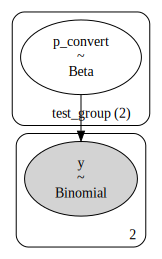

In [19]:
pm.model_to_graphviz(model)

In [20]:
with model:
    idata = pm.sample(chains=4, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_convert]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [21]:
import matplotlib as mpl

mpl.style.use("ggplot")

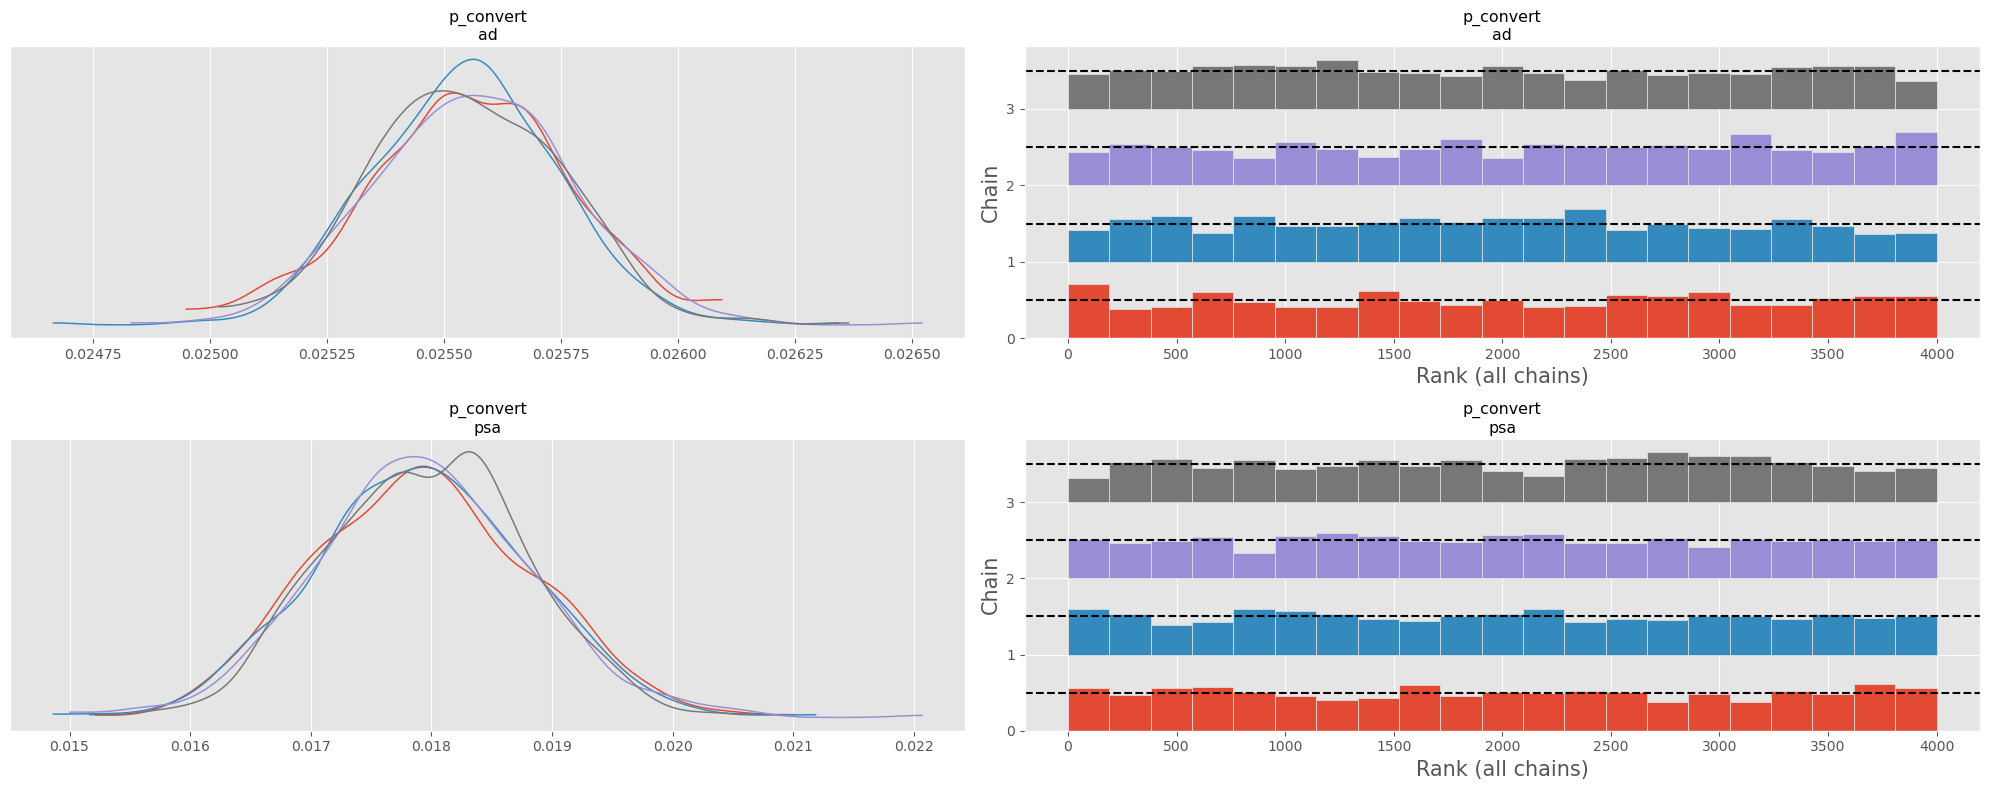

In [22]:
az.plot_trace(
    idata,
    kind="rank_bars",
    compact=False,
    backend_kwargs={"tight_layout": True},
    figsize=(20, 8),
);

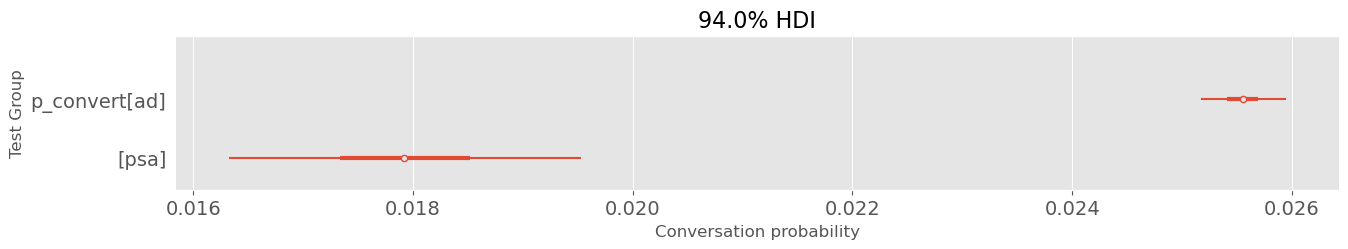

In [23]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 2))

az.plot_forest(
    idata,
    var_names=["p_convert"],
    combined=True,
    backend_kwargs={"tight_layout": True},
    # figsize=(15, 2),
    ax=ax,
)

ax.set(xlabel="Conversation probability", ylabel="Test Group");

In [51]:
summarized_hour_df = dataf.assign(
    converted=lambda d: d["converted"].astype(int),
    most_ads_day_cat=lambda d: d["most_ads_day"].astype("category").cat.codes,
).query("test_group=='ad'")
summarized_hour_df.sample(3)

,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour,most_ads_day_cat
514213,1220280,ad,0,2,Wednesday,15,6
259662,1544998,ad,0,3,Monday,20,1
277080,1505993,ad,0,15,Wednesday,16,6


In [52]:
converted = summarized_hour_df["converted"].to_numpy()

with pm.Model(coords=coords) as model:
    eta = pm.Deterministic("eta", β[0] + β[1] * summarized_hour_df["most_ads_day_cat"])

    p_convert = pm.Deterministic("p_convert", pm.math.sigmoid(eta))

    pm.Bernoulli("y", p=p_convert, observed=converted)

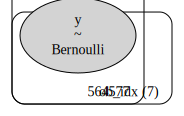

In [53]:
pm.model_to_graphviz(model)

In [ ]:
with model:
    idata = pm.sample(chains=1, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [β]


In [ ]:
az.plot_trace(
    idata,
    var_names=["β"],
    kind="rank_bars",
    compact=True,
    backend_kwargs={"tight_layout": True},
);

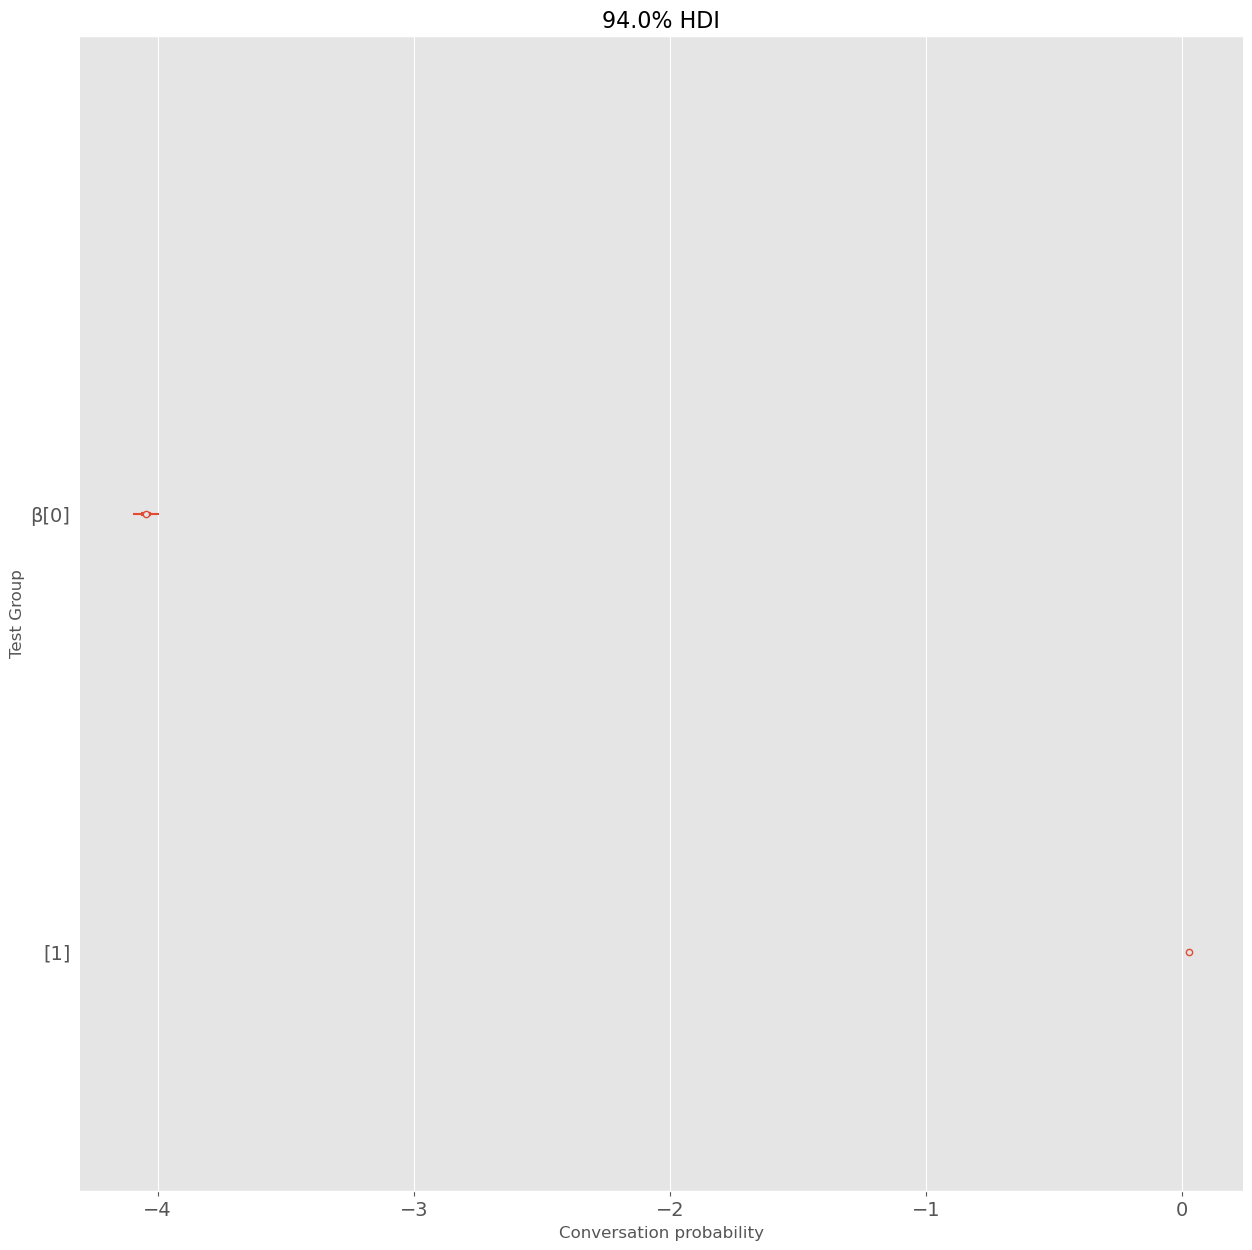

In [170]:
fig, ax = plt.subplots(figsize=(15, 15))

az.plot_forest(
    idata,
    var_names=["β"],
    combined=True,
    backend_kwargs={"tight_layout": True},
    # figsize=(15, 2),
    ax=ax,
)

ax.set(xlabel="Conversation probability", ylabel="Test Group");